In [1]:
import numpy as np
import tensorflow as tf
import tensorlayer as tl
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, History
from keras.losses import *
from keras.utils import Sequence
from data_utilities import DataGenerator
from keras import backend as K
import os, time
from matplotlib import pyplot as plt
from model_utilities import DistortImages, VisualizeImage, VisualizeImageWithPrediction

C:\Users\Razer\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Define our Attention Model Here

Here, We will first define the attention block, then we will use it in a keras model

In [2]:
def AttentionBlock(x, shortcut, num_filters):
    '''
    function that defines the attention gated block for our U-Net Model

    Arguments:
        x {tensor} -- Input from previous decoding upscale layer
        shortcut {tensor} -- Corresponding input from the same level encoder layer
        num_filters {int} -- total filters used for that layer in decoder

    Returns:
        {tensor} -- the output of the attention gate to be concatenated with that layer in decoder
    '''
    g1 = Conv2D(num_filters, kernel_size = 1, kernel_initializer = "he_normal", padding = "same")(shortcut)
    x1 = Conv2D(num_filters, kernel_size = 1, kernel_initializer = "he_normal", padding = "same")(x)
    
    g1_x1 = Add()([g1, x1])
    psi = Activation("relu")(g1_x1)
    psi = Conv2D(1, kernel_size = 1, padding = "same")(psi)
    psi = Activation("sigmoid")(psi)
    x = Multiply()([x, psi])
    return x

In [3]:
def UNet(shape, reuse = False, n_out = 1):
    
    nnx = int(shape[1])
    nny = int(shape[2])
    nnz = int(shape[3])
    print(" * Input: size of image: %d %d %d" % (nnx, nny, nnz))
    with tf.variable_scope("u_net", reuse = reuse):
        
        # Encoder
        inputs = Input((nnx, nny, nnz))
        
        conv1 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(inputs)
        conv1 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv1)
        pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
        
        conv2 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool1)
        conv2 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv2)
        pool2 = MaxPool2D(pool_size = (2, 2))(conv2)
        
        conv3 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool2)
        conv3 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv3)
        pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
        
        conv4 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool3)
        conv4 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv4)
        conv4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)
        
        conv5 = Conv2D(1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool4)
        conv5 = Conv2D(1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv5)
        conv5 = Dropout(0.5)(conv5)
        
        # Decoder ;_;
        up6 = Deconv2D(512, 3, strides = (2, 2), padding = "same")(conv5)
        merge6 = concatenate([conv4, up6], axis = -1)
        conv6 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge6)
        conv6 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv6)
        
        up7 = Deconv2D(256, 3, strides = (2, 2), padding = "same")(conv6)
        merge7 = concatenate([conv3, up7], axis = -1)
        conv7 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge7)
        conv7 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv7)
        
        up8 = Deconv2D(128, 3, strides = (2, 2), padding = "same")(conv7)
        merge8 = concatenate([conv2, up8], axis = -1)
        conv8 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge8)
        conv8 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv8)
        
        up9 = Deconv2D(64, 3, strides = (2, 2), padding = "same")(conv8)
        merge9 = concatenate([conv1, up9], axis = -1)
        conv9 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge9)
        conv9 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv9)
        conv9 = Conv2D(2, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv9)

        conv10 = Conv2D(n_out, 1, activation = "sigmoid", padding = "same", kernel_initializer = "he_normal")(conv9)
        
        model = Model(inputs = inputs, outputs = conv10)
        
        return model

In [4]:
def UNetWithAttention(shape, reuse = False, n_out = 1):
    
    nnx = int(shape[1])
    nny = int(shape[2])
    nnz = int(shape[3])
    print(" * Input: size of image: %d %d %d" % (nnx, nny, nnz))
    with tf.variable_scope("u_net", reuse = reuse):
        
        # Encoder
        inputs = Input((nnx, nny, nnz))
        
        conv1 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(inputs)
        conv1 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv1)
        pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
        
        conv2 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool1)
        conv2 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv2)
        pool2 = MaxPool2D(pool_size = (2, 2))(conv2)
        
        conv3 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool2)
        conv3 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv3)
        pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
        
        conv4 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool3)
        conv4 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv4)
        conv4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)
        
        conv5 = Conv2D(1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool4)
        conv5 = Conv2D(1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv5)
        conv5 = Dropout(0.5)(conv5)
        
        # Decoder ;_;
        up6 = Deconv2D(512, 3, strides = (2, 2), padding = "same")(conv5)
        attn6 = AttentionBlock(up6, conv4, 512)
        merge6 = concatenate([attn6, up6], axis = -1)
        conv6 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge6)
        conv6 = Conv2D(512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv6)
        
        up7 = Deconv2D(256, 3, strides = (2, 2), padding = "same")(conv6)
        attn7 = AttentionBlock(up7, conv3, 256)
        merge7 = concatenate([attn7, up7], axis = -1)
        conv7 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge7)
        conv7 = Conv2D(256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv7)
        
        up8 = Deconv2D(128, 3, strides = (2, 2), padding = "same")(conv7)
        attn8 = AttentionBlock(up8, conv2, 128)
        merge8 = concatenate([attn8, up8], axis = -1)
        conv8 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge8)
        conv8 = Conv2D(128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv8)
        
        up9 = Deconv2D(64, 3, strides = (2, 2), padding = "same")(conv8)
        attn9 = AttentionBlock(up9, conv1, 64)
        merge9 = concatenate([attn9, up9], axis = -1)
        conv9 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(merge9)
        conv9 = Conv2D(64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv9)
        conv9 = Conv2D(2, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv9)

        conv10 = Conv2D(n_out, 1, activation = "sigmoid", padding = "same", kernel_initializer = "he_normal")(conv9)
        
        model = Model(inputs = inputs, outputs = conv10)
        
        return model

# Setting up folders for checkpoints and testing

In [5]:
import os
save_dir = "./checkpoint"
task = "all"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
if not os.path.exists("./sample/{}".format(task)):
    os.mkdir("./sample")
    os.mkdir("./sample/{}".format(task))

In [6]:
if not os.path.exists("./test/{}".format(task)):
    os.mkdir("./test")
    os.mkdir("./test/{}".format(task))

## Prepare and load data
Here, we will load the entire data and preprocess it as and when necessary.

In [7]:
import prepare_data_with_valid4 as dataset

28
13
28
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
(1, 240, 240, 153)
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
(1, 240, 240, 153)
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
(1, 240, 240, 153)
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
(1, 240, 240, 153)
{'DWI': {'mean': 21.078682, 'std': 44.95277}, 'Flair': {'mean': 24.302284, 'std': 50.49608}, 'T1': {'mean': 31.60154, 'std': 63.932735}, 'T2': {'mean': 44.153976, 'std': 92.98761}}
 HGG Validation
finished 22
finished 23
finished 24
finished 25
finished 26
finished 27
finished 28
(1071, 240, 240, 4)
(1071, 240, 240)
 HGG Train
finished 1
finished 2
finished 3
finished 4
finished 5
finished 6
finished 7
finished 8
finished 9
finished 10
finished 11
finished 12
finished 13
finished 14
finished 15

In [8]:
XTrain = dataset.X_train_input
yTrain = dataset.X_train_target[:, :, :, np.newaxis]
XTest = dataset.X_dev_input
yTest = dataset.X_dev_target[:, :, :, np.newaxis]

yTrain = (yTrain > 0).astype(int)
yTest = (yTest > 0).astype(int)

# Visualize a slice
X = np.asarray(XTrain[80])
y = np.asarray(yTrain[80])
nw, nh, nz = X.shape
VisualizeImage(X, y, 'sample/{}/_train_im.png'.format(task))

In [9]:
yTrain.shape

(3060, 240, 240, 1)

In [10]:
yTest_ar = np.asarray(yTest)
yTest_ar = np.squeeze(yTest)
yTest_ar.shape
y_sq = np.squeeze(y)

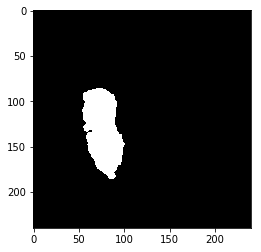

In [11]:
plt.imshow(y_sq, cmap = "gray")

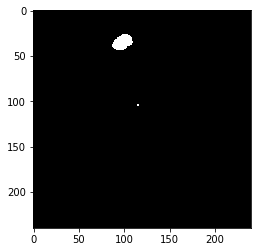

In [12]:
plt.imshow(yTest_ar[48, :, :], cmap = "gray")

# Data Augmentation Testing

Here, we will check the preprocessing functions and make sure that they work properly

In [13]:
# Show the data augmentation
for i in range(10):
    x_flair, x_t1, x_t1ce, x_t2, label = DistortImages([X[:, :, 0, np.newaxis], 
                                                   X[:, :, 1, np.newaxis], 
                                                   X[:, :, 2, np.newaxis], 
                                                   X[:, :, 3, np.newaxis], y])
    X_dis = np.concatenate((x_flair, x_t1, x_t1ce, x_t2), axis = 2)
    X_d = np.concatenate((X[:, :, 0, np.newaxis], X[:, :, 1, np.newaxis], X[:, :, 2, np.newaxis], X[:, :, 3, np.newaxis]), axis = 2)
    VisualizeImage(X_dis, label, 'sample/{}/_train_im_aug{}.png'.format(task, i))
    VisualizeImage(X_d, label, 'sample/{}/_sample_im_aug{}.png'.format(task, i))
    if i == 0:
        print(x_flair.shape, x_t1.shape, x_t1ce.shape, x_t2.shape, label.shape, sep="\n")
        print(X_dis.shape, X_dis.min(), X_dis.max(), sep="\n")

(240, 240, 1)
(240, 240, 1)
(240, 240, 1)
(240, 240, 1)
(240, 240, 1)
(240, 240, 4)
-0.4942935705184938
28.5815349355855


## HyperParameter Setting
Here we will set the hyperparams necessary to jolt our model for training

In [14]:
batch_size = 5
lr = 0.0001
beta1 = 0.9
n_epoch = 5
printFreq = 10

## Define our Loss Functions here

In [15]:
def dice_coef(y_true, y_pred, smooth = 1):
    '''
    Function that defines the dice_coef
    Dice = (2*|X & Y|)/ (|X|+ |Y|) = 2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    '''
    intersection = K.sum(K.abs(y_true * y_pred), axis = -1)
    return (2. * intersection + smooth)/(K.sum(K.square(y_true), -1) + K.sum(K.square(y_pred), -1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

## Train our model

In [19]:
model = UNet(shape = (batch_size, nw, nh, nz))
model.compile(optimizer = Adam(lr=lr, beta_1=beta1), loss = dice_coef_loss, metrics = [dice_coef])

 * Input: size of image: 240 240 4


In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 240, 240, 4)  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 240, 240, 64) 2368        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 240, 240, 64) 36928       conv2d_21[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 120, 120, 64) 0           conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv2d_23 

In [21]:
trainGen = DataGenerator(XTrain, yTrain, batch_size = batch_size)

In [22]:
model.fit_generator(generator = trainGen,steps_per_epoch = 3060 // batch_size, epochs = n_epoch)

Epoch 1/5


177/612 [=======>......................] - ETA: 2:07:45 - loss: 0.2072 - dice_coef: 0.79 - ETA: 1:06:12 - loss: 0.2010 - dice_coef: 0.79 - ETA: 45:41 - loss: 0.1953 - dice_coef: 0.8047 - ETA: 35:25 - loss: 0.1869 - dice_coef: 0.81 - ETA: 29:15 - loss: 0.1844 - dice_coef: 0.81 - ETA: 25:09 - loss: 0.1779 - dice_coef: 0.82 - ETA: 22:12 - loss: 0.1756 - dice_coef: 0.82 - ETA: 19:59 - loss: 0.1728 - dice_coef: 0.82 - ETA: 18:16 - loss: 0.1660 - dice_coef: 0.83 - ETA: 16:54 - loss: 0.1577 - dice_coef: 0.84 - ETA: 15:46 - loss: 0.1491 - dice_coef: 0.85 - ETA: 14:50 - loss: 0.1382 - dice_coef: 0.86 - ETA: 14:02 - loss: 0.1280 - dice_coef: 0.87 - ETA: 13:20 - loss: 0.1193 - dice_coef: 0.88 - ETA: 12:45 - loss: 0.1114 - dice_coef: 0.88 - ETA: 12:14 - loss: 0.1044 - dice_coef: 0.89 - ETA: 11:46 - loss: 0.0994 - dice_coef: 0.90 - ETA: 11:21 - loss: 0.0939 - dice_coef: 0.90 - ETA: 10:59 - loss: 0.0892 - dice_coef: 0.91 - ETA: 10:39 - loss: 0.0853 - dice_coef: 0.91 - ETA: 10:21 - loss: 0.0813 - dic

355/612 [================>.............] - ETA: 3:55 - loss: 0.0140 - dice_coef: 0.986 - ETA: 3:54 - loss: 0.0139 - dice_coef: 0.986 - ETA: 3:53 - loss: 0.0139 - dice_coef: 0.986 - ETA: 3:52 - loss: 0.0138 - dice_coef: 0.986 - ETA: 3:52 - loss: 0.0137 - dice_coef: 0.986 - ETA: 3:51 - loss: 0.0136 - dice_coef: 0.986 - ETA: 3:50 - loss: 0.0136 - dice_coef: 0.986 - ETA: 3:50 - loss: 0.0135 - dice_coef: 0.986 - ETA: 3:49 - loss: 0.0134 - dice_coef: 0.986 - ETA: 3:48 - loss: 0.0134 - dice_coef: 0.986 - ETA: 3:48 - loss: 0.0133 - dice_coef: 0.986 - ETA: 3:47 - loss: 0.0132 - dice_coef: 0.986 - ETA: 3:46 - loss: 0.0132 - dice_coef: 0.986 - ETA: 3:46 - loss: 0.0131 - dice_coef: 0.986 - ETA: 3:45 - loss: 0.0130 - dice_coef: 0.987 - ETA: 3:44 - loss: 0.0130 - dice_coef: 0.987 - ETA: 3:44 - loss: 0.0129 - dice_coef: 0.987 - ETA: 3:43 - loss: 0.0128 - dice_coef: 0.987 - ETA: 3:42 - loss: 0.0128 - dice_coef: 0.987 - ETA: 3:42 - loss: 0.0127 - dice_coef: 0.987 - ETA: 3:41 - loss: 0.0127 - dice_coef:

534/612 [=========================>....] - ETA: 2:10 - loss: 0.0086 - dice_coef: 0.991 - ETA: 2:09 - loss: 0.0086 - dice_coef: 0.991 - ETA: 2:09 - loss: 0.0086 - dice_coef: 0.991 - ETA: 2:08 - loss: 0.0086 - dice_coef: 0.991 - ETA: 2:08 - loss: 0.0086 - dice_coef: 0.991 - ETA: 2:07 - loss: 0.0086 - dice_coef: 0.991 - ETA: 2:07 - loss: 0.0085 - dice_coef: 0.991 - ETA: 2:06 - loss: 0.0085 - dice_coef: 0.991 - ETA: 2:06 - loss: 0.0085 - dice_coef: 0.991 - ETA: 2:05 - loss: 0.0085 - dice_coef: 0.991 - ETA: 2:05 - loss: 0.0085 - dice_coef: 0.991 - ETA: 2:04 - loss: 0.0084 - dice_coef: 0.991 - ETA: 2:03 - loss: 0.0084 - dice_coef: 0.991 - ETA: 2:03 - loss: 0.0084 - dice_coef: 0.991 - ETA: 2:02 - loss: 0.0084 - dice_coef: 0.991 - ETA: 2:02 - loss: 0.0084 - dice_coef: 0.991 - ETA: 2:01 - loss: 0.0084 - dice_coef: 0.991 - ETA: 2:01 - loss: 0.0083 - dice_coef: 0.991 - ETA: 2:00 - loss: 0.0083 - dice_coef: 0.991 - ETA: 2:00 - loss: 0.0083 - dice_coef: 0.991 - ETA: 1:59 - loss: 0.0083 - dice_coef:

612/612 [==============================] - ETA: 38s - loss: 0.0068 - dice_coef: 0.99 - ETA: 37s - loss: 0.0068 - dice_coef: 0.99 - ETA: 37s - loss: 0.0068 - dice_coef: 0.99 - ETA: 36s - loss: 0.0068 - dice_coef: 0.99 - ETA: 36s - loss: 0.0068 - dice_coef: 0.99 - ETA: 35s - loss: 0.0068 - dice_coef: 0.99 - ETA: 35s - loss: 0.0068 - dice_coef: 0.99 - ETA: 34s - loss: 0.0068 - dice_coef: 0.99 - ETA: 34s - loss: 0.0068 - dice_coef: 0.99 - ETA: 33s - loss: 0.0068 - dice_coef: 0.99 - ETA: 33s - loss: 0.0068 - dice_coef: 0.99 - ETA: 32s - loss: 0.0067 - dice_coef: 0.99 - ETA: 32s - loss: 0.0067 - dice_coef: 0.99 - ETA: 31s - loss: 0.0067 - dice_coef: 0.99 - ETA: 31s - loss: 0.0067 - dice_coef: 0.99 - ETA: 30s - loss: 0.0067 - dice_coef: 0.99 - ETA: 30s - loss: 0.0068 - dice_coef: 0.99 - ETA: 29s - loss: 0.0068 - dice_coef: 0.99 - ETA: 29s - loss: 0.0068 - dice_coef: 0.99 - ETA: 28s - loss: 0.0068 - dice_coef: 0.99 - ETA: 28s - loss: 0.0067 - dice_coef: 0.99 - ETA: 27s - loss: 0.0068 - dice_co

146/612 [======>.......................] - ETA: 4:54 - loss: 0.0011 - dice_coef: 0.998 - ETA: 4:57 - loss: 5.3566e-04 - dice_coef: 0.999 - ETA: 4:55 - loss: 0.0066 - dice_coef: 0.9934    - ETA: 4:56 - loss: 0.0085 - dice_coef: 0.991 - ETA: 4:56 - loss: 0.0068 - dice_coef: 0.993 - ETA: 4:55 - loss: 0.0057 - dice_coef: 0.994 - ETA: 4:54 - loss: 0.0049 - dice_coef: 0.995 - ETA: 4:54 - loss: 0.0043 - dice_coef: 0.995 - ETA: 4:53 - loss: 0.0038 - dice_coef: 0.996 - ETA: 4:52 - loss: 0.0042 - dice_coef: 0.995 - ETA: 4:52 - loss: 0.0038 - dice_coef: 0.996 - ETA: 4:51 - loss: 0.0049 - dice_coef: 0.995 - ETA: 4:50 - loss: 0.0045 - dice_coef: 0.995 - ETA: 4:50 - loss: 0.0042 - dice_coef: 0.995 - ETA: 4:49 - loss: 0.0039 - dice_coef: 0.996 - ETA: 4:49 - loss: 0.0036 - dice_coef: 0.996 - ETA: 4:48 - loss: 0.0034 - dice_coef: 0.996 - ETA: 4:48 - loss: 0.0032 - dice_coef: 0.996 - ETA: 4:48 - loss: 0.0031 - dice_coef: 0.996 - ETA: 4:47 - loss: 0.0029 - dice_coef: 0.997 - ETA: 4:46 - loss: 0.0028 - di

KeyboardInterrupt: 

In [ ]:
train_history = History()
for epoch in range(0, n_epoch):
    epoch_time = time.time()
    n_batch = 0
    print("[+] Epoch ==> ",epoch + 1)
    for batch in tl.iterate.minibatches(inputs = XTrain, targets = yTrain, batch_size = batch_size, shuffle = True):
        images, labels = batch

        data = tl.prepro.threading_data([_ for _ in zip(images[:,:,:,0, np.newaxis],
                        images[:,:,:,1, np.newaxis], images[:,:,:,2, np.newaxis],
                        images[:,:,:,3, np.newaxis], labels)], fn = DistortImages)
        bImages = data[:, 0:4, :, :, :]
        bLabels = data[:, 4, :, :, :]
        bImages = bImages.transpose((0, 2, 3, 1, 4))
        bImages.shape = (batch_size, nw, nh, nz)

        model.fit(x = bImages, y = labels, batch_size = batch_size, verbose = 0, shuffle = False, callbacks=[train_history])
        n_batch += 1
        
        if n_batch % printFreq == 0:
            print("batch ==> ", n_batch, ", images parsed ==> ", batch_size * n_batch)
            print(train_history.history)
    
    print("[+] Epoch over ==> ", epoch + 1, " out of ", n_epoch)
    print(train_history.history)

In [ ]:
net_json = model.to_json()
with open("unet.json", "w") as json_file:
    json_file.write(net_json)
model.save_weights("unet.h5")
print("[+] Model Saved in disk")

## Test saved model
### 1. Load the model

In [ ]:
jsonFile = open('unet.json', "r")
loadedModelJson = jsonFile.read()
jsonFile.close()

model = model_from_json(loadedModelJson)
model.load_weights("unet.h5")
print("[+] Model loaded")
model.compile(optimizer = Adam(lr=lr, beta_1=beta1), loss = 'binary_crossentropy', metrics = ["accuracy"])

### 2. Test predictions

In [ ]:
model.evaluate(x = XTest, y = yTest, batch_size = batch_size, verbose = 1)

In [ ]:
outPred = model.predict(XTest, batch_size = batch_size, verbose=1)

In [ ]:
for i in range(outPred.shape[0]):
    VisualizeImageWithPrediction(XTest[i], yTest[i], outPred[i], "./test/{}/test_{}.png".format(task, i))

In [ ]:
outPredTrain = model.predict(XTrain, batch_size = batch_size, verbose=1)

In [ ]:
for i in range(outPred.shape[0]):
    VisualizeImageWithPrediction(XTrain[i], yTrain[i], outPred[i], "./train/{}/train_{}.png".format(task, i))